## Importing Libraries & Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor    

In [2]:
df = pd.read_csv('../data/exports/health_landscape_clean.csv').drop(columns=['avgLifeExpec','strokeDeath_rate'])

In [3]:
def fips_to_obj(df):
    df['FIPS'] = [int(i) for i in df['FIPS'].fillna(0)]
    df['FIPS'] = df['FIPS'].astype('object')
    fips_list = []
    for i in df['FIPS']:
        if len(str(i)) < 5:
            fips_list.append('0' + str(i))
        else:
            fips_list.append(str(i))
    df['FIPS'] = fips_list
    return df

df = fips_to_obj(df)

## Abridged EDA

### Correlations

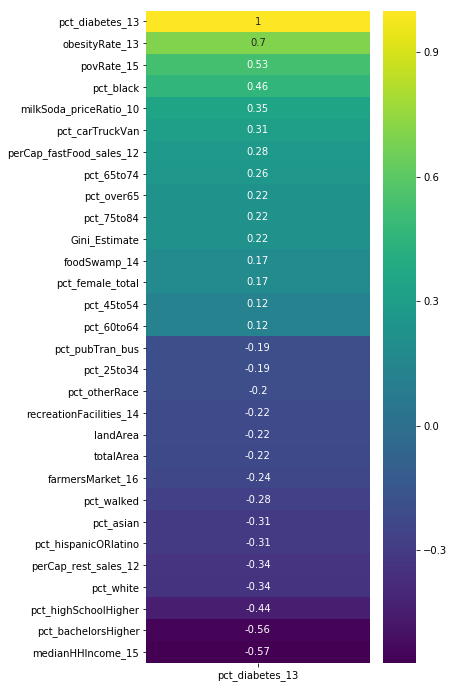

In [4]:
plt.figure(figsize=(5,12))
sns.heatmap(df.corr()[['pct_diabetes_13']].sort_values(by='pct_diabetes_13', ascending=False)\
    .iloc[np.r_[0:15, -15:0]], annot=True, cmap='viridis');

### Scatterplot

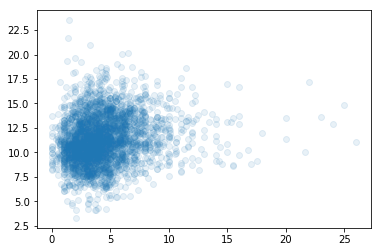

In [5]:
plt.scatter(df['foodSwamp_14'], df['pct_diabetes_13'], alpha = .1);

## Baseline

In [6]:
print('Baseline:',df['pct_diabetes_13'].mean())

Baseline: 11.274088541666677


## Simple OLS Model

In [7]:
# Substituting Median Household Income or Percent Bachelors or Higher for Poverty Rate are both viable
# --> medianHHIncome_15 makes little impact
# --> pct_bachelorsHigher improves scores considerably
X = df[['foodSwamp_14','pct_lowAccessInc_15','recreationFacilities_14', 'povRate_15','natAmenityIndex',
        'milkSoda_priceRatio_10', 'pct_black', 'pct_hispanicORlatino','pct_over65','totalArea']]
y = df['pct_diabetes_13']

lr = LinearRegression()
lr.fit(X, y)
print('Score:',lr.score(X, y))
print('Cross val score:',cross_val_score(lr, X, y, cv=5, scoring='explained_variance').mean())

Score: 0.541207135939274
Cross val score: 0.4823297752933162


In [8]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pct_diabetes_13   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     361.1
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        14:40:23   Log-Likelihood:                -5920.8
No. Observations:                3072   AIC:                         1.186e+04
Df Residuals:                    3061   BIC:                         1.193e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.0383      0.284     14.228      0.000       3.482       4.595
foodSwamp_14                0.1107      0.012      8.925      0.000       0.086       0.135
pct_lowAccessInc_15        -0.0102      0.004     -2.524      0.012      -0.018      -0.002
recreationFacilities_14    -0.0059      0.001     -6.081      0.000      -0.008      -0.004
povRate_15                  0.1589      0.006     27.326      0.000       0.148       0.170
natAmenityIndex            -0.2186      0.034     -6.460      0.000      -0.285      -0.152
milkSoda_priceRatio_10      2.5809      0.261      9.881      0.000       2.069       3.093
pct_black                   3.0849      0.274     11.269      0.000       2.548       3.622
pct_hispanicORlatino       -3.8134      0.260    -14.646      0.000      -4.324      -3.303
pct_over65                 14.9577      0.775     19.300      0.000      13.438      16.477
totalArea               -9.235e-05   2.63e-05     -3.517      0.000      -0.000   -4.09e-05
==============================================================================
Omnibus:                       29.111   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.230
Skew:                           0.053   Prob(JB):                     1.51e-10
Kurtosis:                       3.585   Cond. No.                     4.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
pd.Series([variance_inflation_factor(X.values, i) 
            for i in range(X.shape[1])], 
            index=X.columns)

const                      89.200261
foodSwamp_14                1.189776
pct_lowAccessInc_15         1.137420
recreationFacilities_14     1.166298
povRate_15                  1.540199
natAmenityIndex             1.376809
milkSoda_priceRatio_10      1.402644
pct_black                   1.750550
pct_hispanicORlatino        1.405352
pct_over65                  1.325864
totalArea                   1.356419
dtype: float64

In [10]:
## Next steps: look at how poverty rates interact with prices!